In [176]:
from glob import glob
import os, sys
from functools import partial
import json

from pprint import pprint

import xarray as xr
import pandas as pd
import numpy as np

import cftime

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import pymannkendall
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
import open_ds
import open_zecmip
import utils
import warnings
warnings.filterwarnings('ignore')
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe

import drift_functions
import sn_plotting
import plotting_functions as pf

from importlib import reload
from typing import List, Any, Callable, Union, Tuple, Optional
from numpy.typing import ArrayLike
from matplotlib.axes import Axes

from listXarray import listXarray
import cartopy.feature as cf

logger = utils.get_notebook_logger()

In [177]:
import listXarray
reload(listXarray)
from listXarray import listXarray

In [178]:
notebook_number = 'draft_07_zec'

In [179]:
os.listdir(constants.ZECMIP_LOCAL_REGRIDDED_DIR)

['esm-piControl',
 '1pct',
 'old',
 'A1',
 'landsea_mask.nc',
 'signal_to_noise',
 '.ipynb_checkpoints',
 'picontrol']

In [180]:
a1_raw_xrlist = open_zecmip.extract_experiment_into_xrlist('1000pgc', 'tas', logginglevel='INFO').to_dataarray('tas').sort_by_refkey()

- ACCESS-ESM1-5
- r1i1p1f1 - /g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191206/*.nc
- CanESM5
- r1i1p2f1 - /g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429/*.nc
- r4i1p2f1 - /g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r2i1p2f1/Amon/tas/gn/v20190429/*.nc
- r5i1p2f1 - /g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r5i1p2f1/Amon/tas/gn/v20190429/*.nc
- r2i1p2f1 - /g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r2i1p2f1/Amon/tas/gn/v20190429/*.nc
- r3i1p2f1 - /g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429/*.nc
- MIROC-ES2L
- r1i1p1f2 - /g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622/*.nc
- UKESM1-0-LL
- r1i1p1f2 - /g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/t

In [181]:
pct_raw_xrlist =  open_zecmip.extract_experiment_into_xrlist('1pct', 'tas').to_dataarray('tas').sort_by_refkey()
esmpi_raw_xrlist =  (open_zecmip.extract_experiment_into_xrlist('esm-piControl', 'tas').to_dataarray('tas')
                     .squeeze('ensemble').sort_by_refkey())

In [182]:
# Match all the ensemble dimensions
pct_raw_xrlist = pct_raw_xrlist.cross_match_dim(a1_raw_xrlist, 'ensemble')
a1_raw_xrlist = a1_raw_xrlist.cross_match_dim(pct_raw_xrlist, 'ensemble')

In [183]:
a1_raw_xrlist.dim('ensemble')

ACCESS-ESM1-5 - ['r1i1p1f1']
CESM2 - ['r1i1p1f1']
CanESM5 - ['r1i1p2f1' 'r2i1p2f1' 'r3i1p2f1']
GFDL-ESM4 - ['r1i1p1f1']
GISS-E2-1-G-CC - ['r1i1p1f1']
MIROC-ES2L - ['r1i1p1f2']
MPI-ESM1-2-LR - ['r1i1p1f1']
NorESM2-LM - ['r1i1p1f1']
UKESM1-0-LL - ['r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2']


In [184]:
pct_raw_xrlist.dim('ensemble')

ACCESS-ESM1-5 - ['r1i1p1f1']
CESM2 - ['r1i1p1f1']
CanESM5 - ['r1i1p2f1' 'r2i1p2f1' 'r3i1p2f1']
GFDL-ESM4 - ['r1i1p1f1']
GISS-E2-1-G-CC - ['r1i1p1f1']
MIROC-ES2L - ['r1i1p1f2']
MPI-ESM1-2-LR - ['r1i1p1f1']
NorESM2-LM - ['r1i1p1f1']
UKESM1-0-LL - ['r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2']


In [185]:
# Convert to celcius
a1_raw_xrlist = a1_raw_xrlist - 273.15
pct_raw_xrlist = pct_raw_xrlist - 273.15
esmpi_raw_xrlist = esmpi_raw_xrlist - 273.15

In [186]:
esmpi_xrlist = esmpi_raw_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')
pct_xrlist = pct_raw_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')
a1_xrlist = a1_raw_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')

In [187]:
esmpi_xrlist

key_dim = model


Number of da/ds: 9
---------------
['ACCESS-ESM1-5']({'model': 1, 'time': 500, 'lat': 145, 'lon': 192})
['CESM2']       ({'model': 1, 'time': 500, 'lat': 192, 'lon': 288})
['CanESM5']     ({'model': 1, 'time': 1000, 'lat': 64, 'lon': 128})
['GFDL-ESM4']   ({'model': 1, 'time': 500, 'lat': 180, 'lon': 288})
['GISS-E2-1-G-CC']({'model': 1, 'time': 170, 'lat': 90, 'lon': 144})
['MIROC-ES2L']  ({'model': 1, 'time': 500, 'lat': 64, 'lon': 128})
['MPI-ESM1-2-LR']({'model': 1, 'time': 500, 'lat': 96, 'lon': 192})
['NorESM2-LM']  ({'model': 1, 'time': 250, 'lat': 96, 'lon': 144})
['UKESM1-0-LL'] ({'model': 1, 'time': 250, 'lat': 144, 'lon': 192})

In [188]:
# The global weighted mean
esmpi_smean_xrlist = esmpi_xrlist.apply(sn.calculate_global_value, 'tas')
pct_smean_xrlist = pct_xrlist.apply(sn.calculate_global_value, 'tas')
a1_smean_xrlist = a1_xrlist.apply(sn.calculate_global_value, 'tas')

In [189]:
def calculate_branch_average(ds_1pct, ds_a1, upper_limit=10, lower_limit=10, logginglevel='ERROR'):
    
    utils.change_logginglevel(logginglevel)
    
    # Get the branch start time
    branch_start_time = ds_a1.time.values[0]
    
    # Get time values from ds_1pct
    onepct_time_values = ds_1pct.time.values
    logger.info(f'{branch_start_time=}')
    
    # Find the index of the branch start time in onepct_time_values
    onepct_branch_arg = np.where(onepct_time_values == branch_start_time)[0][0]
    
    logger.info(f'{onepct_branch_arg=}')
    
    ds_1pct_branch_slice = ds_1pct.isel(time=slice(onepct_branch_arg-lower_limit, onepct_branch_arg+upper_limit))
    
    logger.info(f'Time values around branch point {len(ds_1pct_branch_slice.time.values)}')
    logger.debug(ds_1pct_branch_slice.time.values)
    
    
    branch_point_mean = ds_1pct_branch_slice.mean(dim='time')
    
    return branch_point_mean    

In [190]:
# Calculate the values at the branching point
branch_point_mean_xrlist = listXarray([calculate_branch_average(pct_smean_xrlist[model], a1_smean_xrlist[model]) for model in pct_smean_xrlist.refkeys])

In [191]:
branch_point_mean_xrlist = branch_point_mean_xrlist.set_refkeys('model')

In [192]:
a1_smean_anom_xrlist = (a1_smean_xrlist - branch_point_mean_xrlist).compute()

In [193]:
# This way procudes the same as when you average first then take the anomalies. However, we also get the anomaleis
# time series which is useful
zec25_xrlist = a1_smean_anom_xrlist.isel(time=slice(15, 35)).mean(dim='time')
zec50_xrlist = a1_smean_anom_xrlist.isel(time=slice(40, 60)).mean(dim='time')

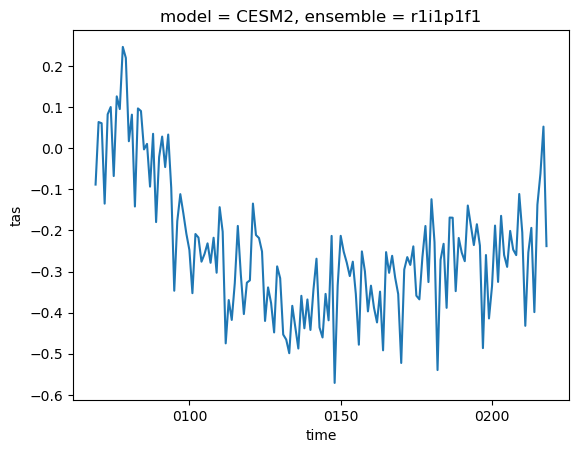

In [194]:
a1_smean_anom_xrlist.single_xarray(1).plot(x='time', hue='ensemble')

In [195]:
zec25_xrlist.single_xarray(2)

<xarray.DataArray 'tas' (ensemble: 3, model: 1)>
array([[-0.01000086],
       [ 0.05800276],
       [-0.15217667]])
Coordinates:
  * model     (model) <U7 'CanESM5'
  * ensemble  (ensemble) <U8 'r1i1p2f1' 'r2i1p2f1' 'r3i1p2f1'

# ZEC anomly period analysis

## Global Values

In [196]:
def calculate_rolling_period_diff(da: xr.DataArray, period:int) -> xr.DataArray:
    """
    Calculate the rolling period difference between two slices of a given DataArray.
    Parameters:
        da (xr.DataArray): Input DataArray.
    Returns:
        xr.DataArray: Rolling period difference.
    """
    # Get the length of the time dimension
    time_length = len(da.time.values)

    # Slice from the start until the final 25 time steps
    slice1 = da.isel(time=slice(None, time_length - period))
    # Slice from year 25 until the end
    slice2 = da.isel(time=slice(period, None))

    # Calculate the rolling mean with a window size of 20 and drop NA values
    slice1_rolling = slice1.rolling(time=20).mean(dim='time').dropna(dim='time')
    slice2_rolling = slice2.rolling(time=20).mean(dim='time').dropna(dim='time')

    # Calculate the difference between the two rolling means
    diff_np = slice2_rolling.values - slice1_rolling.values

    # Create a new DataArray with the same dimensions as the sliced data
    diff_da = xr.zeros_like(da.isel(time=slice(None, len(slice1_rolling.time.values))))
    diff_da += diff_np

    return diff_da

In [197]:
# ZEC25 starts at year 15, base period finishes year 10 => 5 years
# ZEC50 starts at year 40, base period finishes year 10 => 30 years
esmpi_zec25_xrlist = esmpi_smean_xrlist.apply(calculate_rolling_period_diff, period=5)
esmpi_zec50_xrlist = esmpi_smean_xrlist.apply(calculate_rolling_period_diff, period=30)

In [198]:
def plot_histogram(da: listXarray, bins: Union[List[float], np.ndarray],
                   step: int, zec_vals: listXarray = None, bar_label: str = '',
                   line_label: str = '', bar_color: str = 'blue', line_color: str = 'red',
                   fig: Optional[plt.Figure] = None, axes: Optional[List[plt.Axes]] = None,
                   add_legend: bool = False, title_loc: str = 'regular', label_ensemble:bool=False) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    Plot histograms for the given DataArray and models.
    ...
    """

    models = da.model.values if isinstance(da, (xr.Dataset, xr.DataArray)) else da.refkeys

    if fig is None and axes is None:
        fig = plt.figure(figsize=(15, 8))
        ncols = 3
        nrows = int(np.ceil(len(models) / ncols))
        gs = gridspec.GridSpec(nrows, ncols, hspace=0.45)
        axes = [fig.add_subplot(gs[i]) for i in range(nrows * ncols)]

    for ax, model in zip(axes, models):
        vals = da.sel(model=model) if isinstance(da, (xr.Dataset, xr.DataArray)) else da[model]
        hist, edges = np.histogram(vals.values, bins=bins)
        
        ax.bar(edges[:-1], hist / len(vals.time.values), alpha=0.5, width=step, label=bar_label, color=bar_color)
        
        if zec_vals is not None:
            for ensemble, zec_val in zip(zec_vals[model].ensemble.values, zec_vals[model].values):
                label = line_label if ensemble == zec_vals[model].ensemble.values[0] else None
                ax.axvline(zec_val, 0, 1, color=line_color, label=label, linewidth=2)
                if label_ensemble:
                    ax.annotate(ensemble, xy=(zec_val+0.01 if zec_val>0 else zec_val-0.01, 0.19),
                                size=6, va='top', ha='center', color=line_color, clip_on=False, rotation=90)

        ax.set_title(model if title_loc == 'regular' else '')
        ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction' if title_loc != 'regular' else 'figure fraction')
        
        ax.set_ylim(0, 0.19)
        ax.set_xlabel(r'Temperature Anomaly ($^\circ C$)', fontsize=14)
        ax.set_ylabel('Frequency')
        
        if add_legend and ax is axes[0]:
            ax.legend(loc='upper left')

    return fig, axes


In [199]:
bound = 0.32; step=0.01
bins = np.arange(-bound, bound+step, step)

In [200]:
repated_kwargs = dict(bins=bins, step=step, add_legend=False)

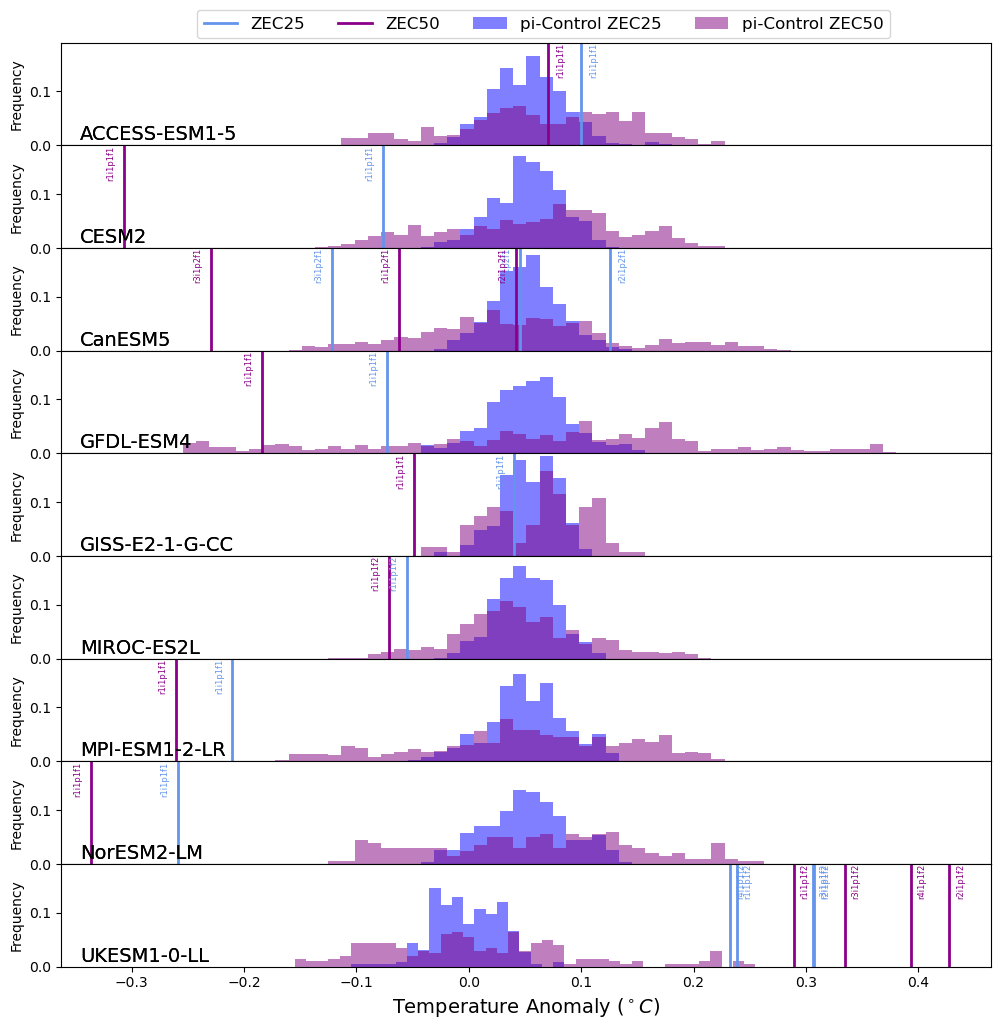

In [201]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(9, 1, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]


fig, axes = plot_histogram(esmpi_zec25_xrlist, zec_vals=zec25_xrlist, line_label='ZEC25', bar_label='pi-Control ZEC25', fig=fig, axes=axes, 
                           line_color='cornflowerblue', title_loc='', label_ensemble=True, **repated_kwargs)
fig, axes = plot_histogram(esmpi_zec50_xrlist, zec_vals=zec50_xrlist, title_loc='', line_label='ZEC50',
                           bar_label='pi-Control ZEC50', fig=fig, axes=axes,
                 bar_color='purple', line_color='darkmagenta', label_ensemble=True, **repated_kwargs)

leg = axes[0].legend(ncol=4, bbox_to_anchor=[0.9, 1.4], fontsize=12)

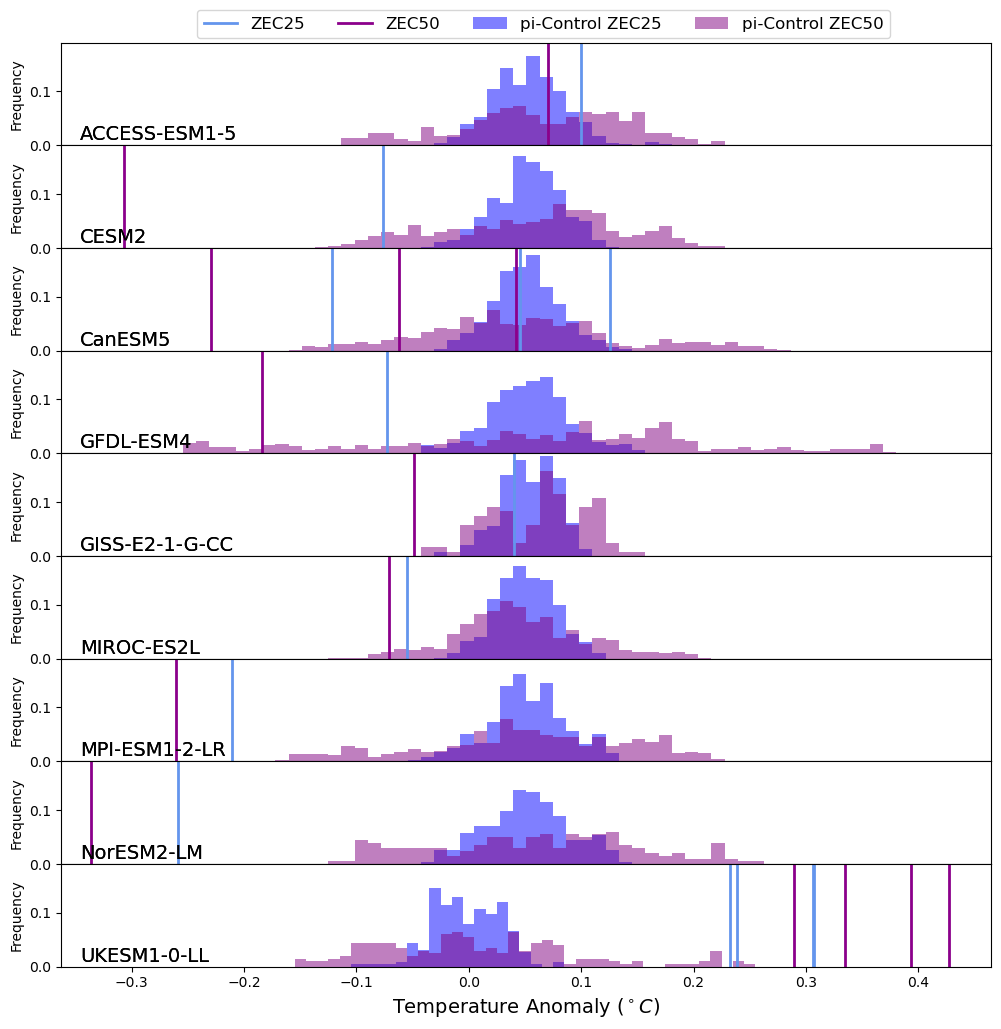

In [202]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(9, 1, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]


fig, axes = plot_histogram(esmpi_zec25_xrlist, zec_vals=zec25_xrlist, line_label='ZEC25', bar_label='pi-Control ZEC25', fig=fig, axes=axes, 
                           line_color='cornflowerblue', title_loc='', **repated_kwargs)
fig, axes = plot_histogram(esmpi_zec50_xrlist, zec_vals=zec50_xrlist, title_loc='', line_label='ZEC50', bar_label='pi-Control ZEC50', fig=fig, axes=axes,
                 bar_color='purple', line_color='darkmagenta', **repated_kwargs)

leg = axes[0].legend(ncol=4, bbox_to_anchor=[0.9, 1.4], fontsize=12)

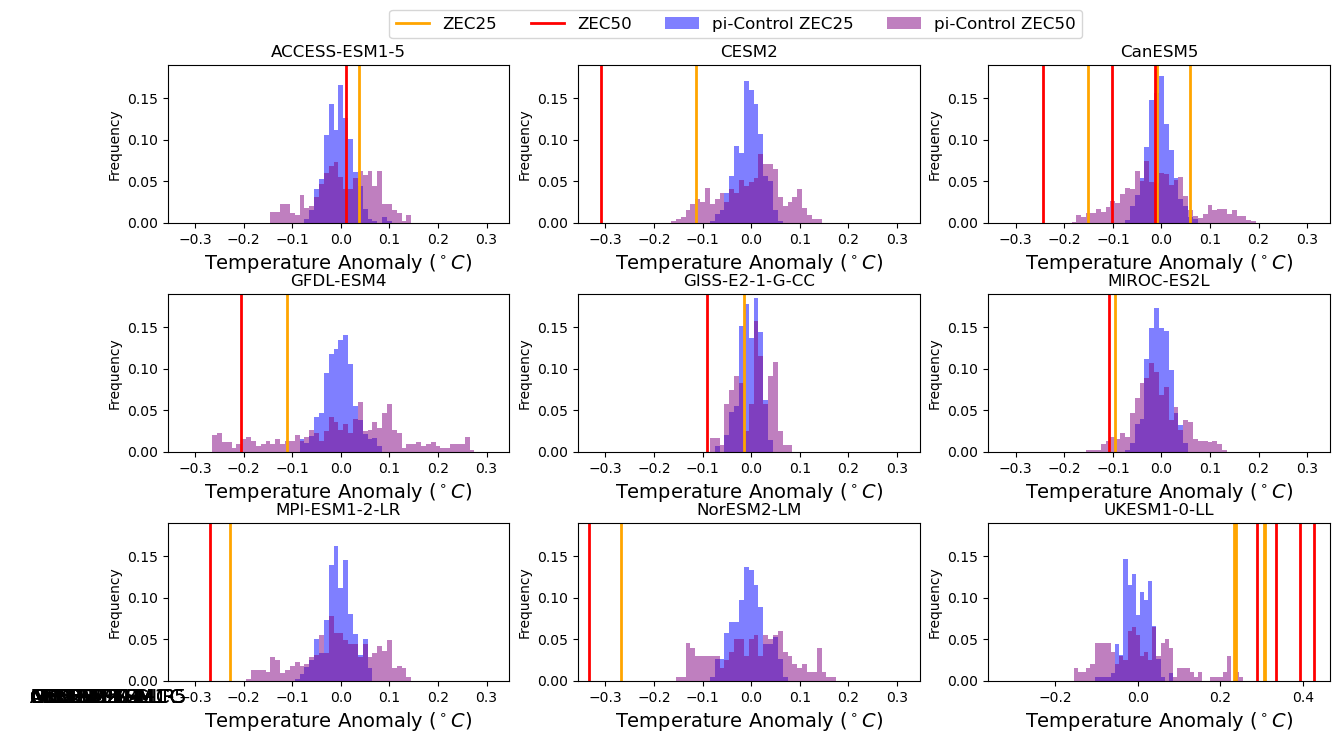

In [203]:
fig, axes = plot_histogram(esmpi_zec25_xrlist, zec_vals=zec25_xrlist, line_label='ZEC25', bar_label='pi-Control ZEC25', 
                           line_color='orange', **repated_kwargs)
fig, axes = plot_histogram(esmpi_zec50_xrlist, zec_vals=zec50_xrlist, line_label='ZEC50', bar_label='pi-Control ZEC50', fig=fig, axes=axes,
                 bar_color='purple', line_color='red', **repated_kwargs)
leg = axes[1].legend(ncol=4, bbox_to_anchor=[1.5, 1.4], fontsize=12)

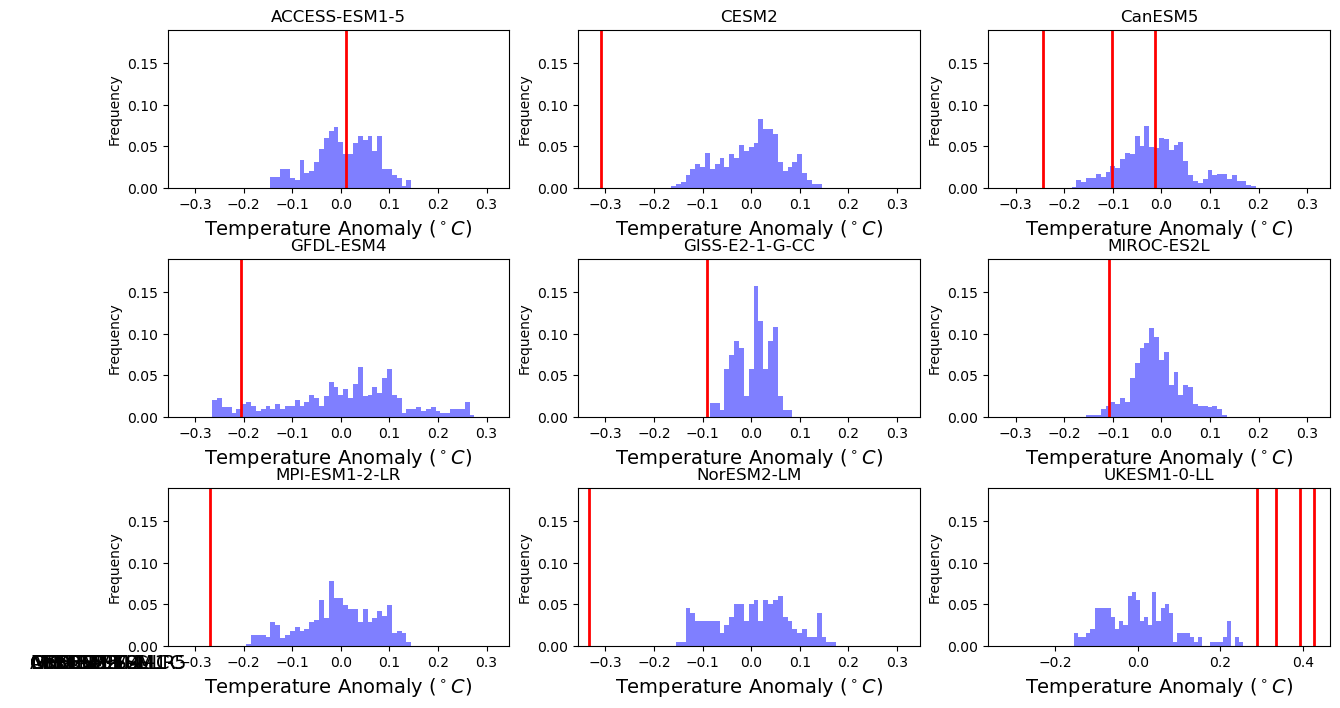

In [204]:
fig, axes = plot_histogram(esmpi_zec50_xrlist, zec_vals=zec50_xrlist, line_label='ZEC50', bar_label='pi-Control ZEC50', **repated_kwargs)

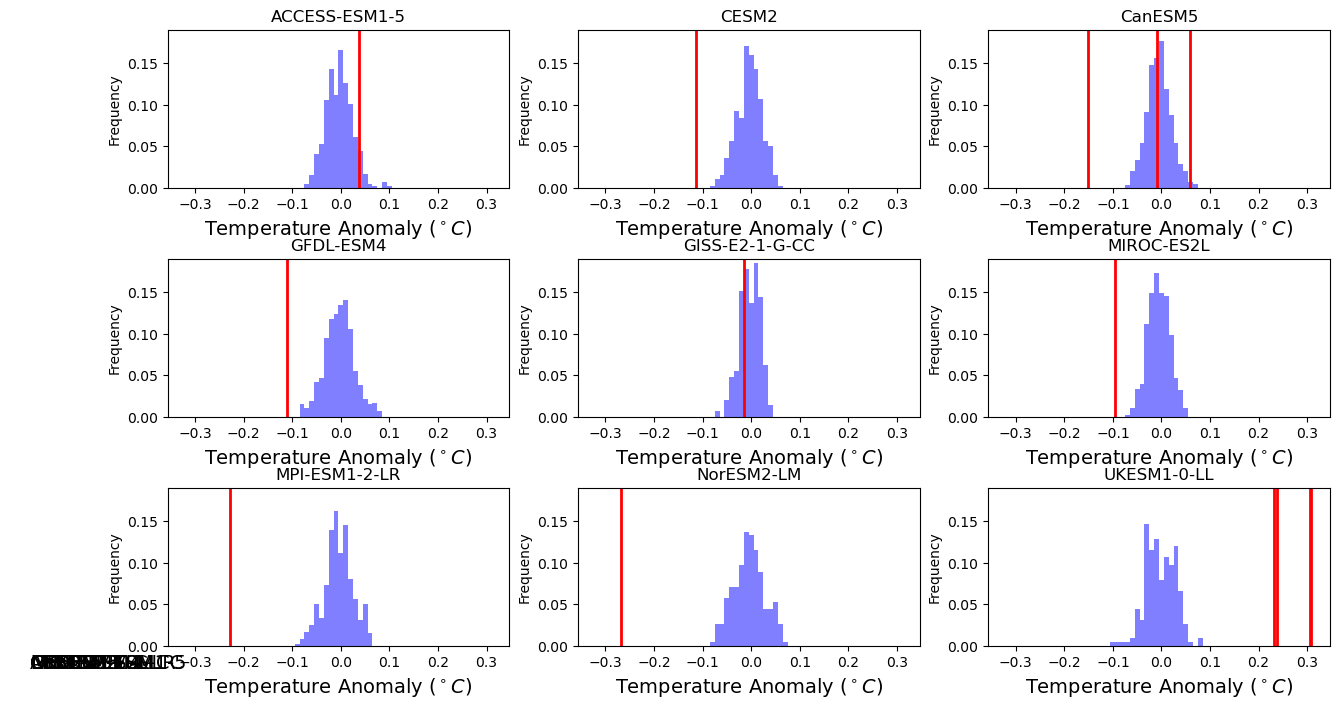

In [205]:
fig, axes = plot_histogram(esmpi_zec25_xrlist, zec_vals=zec25_xrlist, line_label='ZEC25', bar_label='pi-Control ZEC25', **repated_kwargs)

# Local Analysis

In [206]:
# Calculte the anomaly at the branch point
branch_point_xrlist = listXarray([calculate_branch_average(pct_xrlist[model], a1_xrlist[model]) for model in pct_xrlist.refkeys]).set_refkeys('model')

In [207]:
a1_anom_xrlist = (a1_xrlist - branch_point_xrlist).compute()

In [208]:
# This way procudes the same as when you average first then take the anomalies. However, we also get the anomaleis
# time series which is useful
zec25_local_xrlist = a1_anom_xrlist.isel(time=slice(15, 35)).mean(dim='time').sort_by_refkey()
zec50_local_xrlist = a1_anom_xrlist.isel(time=slice(40, 60)).mean(dim='time').sort_by_refkey()

In [209]:
zec90_local_xrlist = a1_anom_xrlist.isel(time=slice(80, 100)).mean(dim='time').sort_by_refkey()

In [210]:
reload(sn_plotting)

<module 'sn_plotting' from '/home/563/ab2313/Documents/PhD/modules/sn_plotting.py'>

- Input type = <class 'listXarray.listXarray'>
- =>Starting plot loop

- num=0 - dv='ACCESS-ESM1-5'


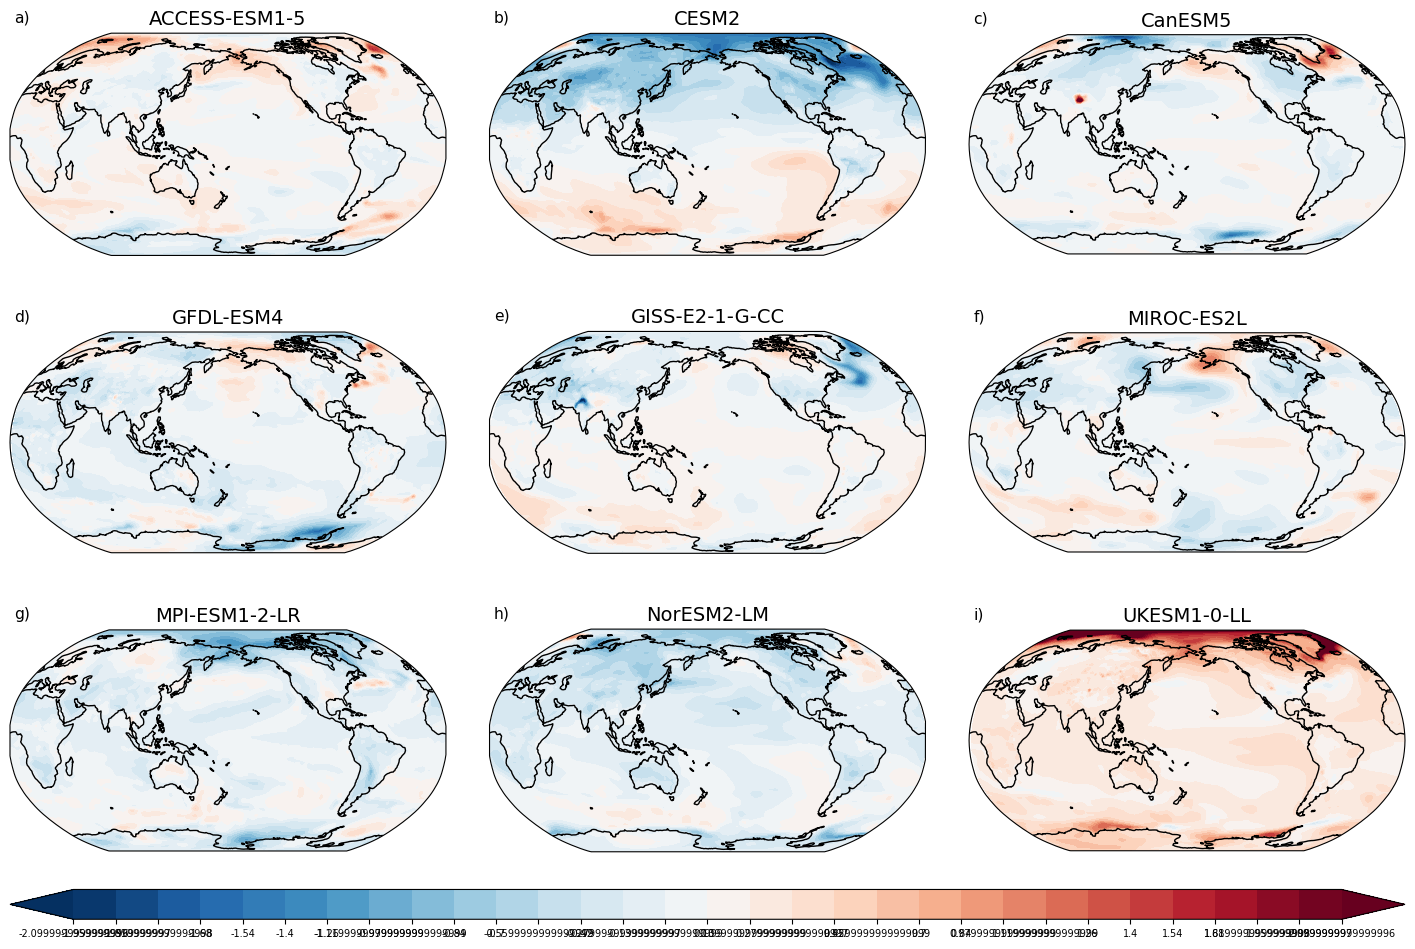

In [211]:
# !!! Warning -  this errors a few times before it runs. It's to do with the type(listXarray).
# Not sure why this is occuring

models = zec50_local_xrlist.refkeys
nrows = 4; ncols = 3
fig = plt.figure(figsize=(6*ncols, 4*ncols))
gs = gridspec.GridSpec(nrows, ncols, height_ratios = [1]*3 + [0.1], hspace=0, wspace=0.1)
cax = plt.subplot(gs[3, :])

zec_kwargs = dict(levels=np.arange(-3, 3.2, .2), extend='both', cmap='RdBu_r', font_scale=0.7)

fig, gs, axes1, cbar = sn_plotting.map_plot_all_for_coords_3(
    zec50_local_xrlist.mean(dim='ensemble'), dim='model', fig=fig, gs=gs, cax=cax, add_colorbar=True,
    logginglevel='INFO', **zec_kwargs)

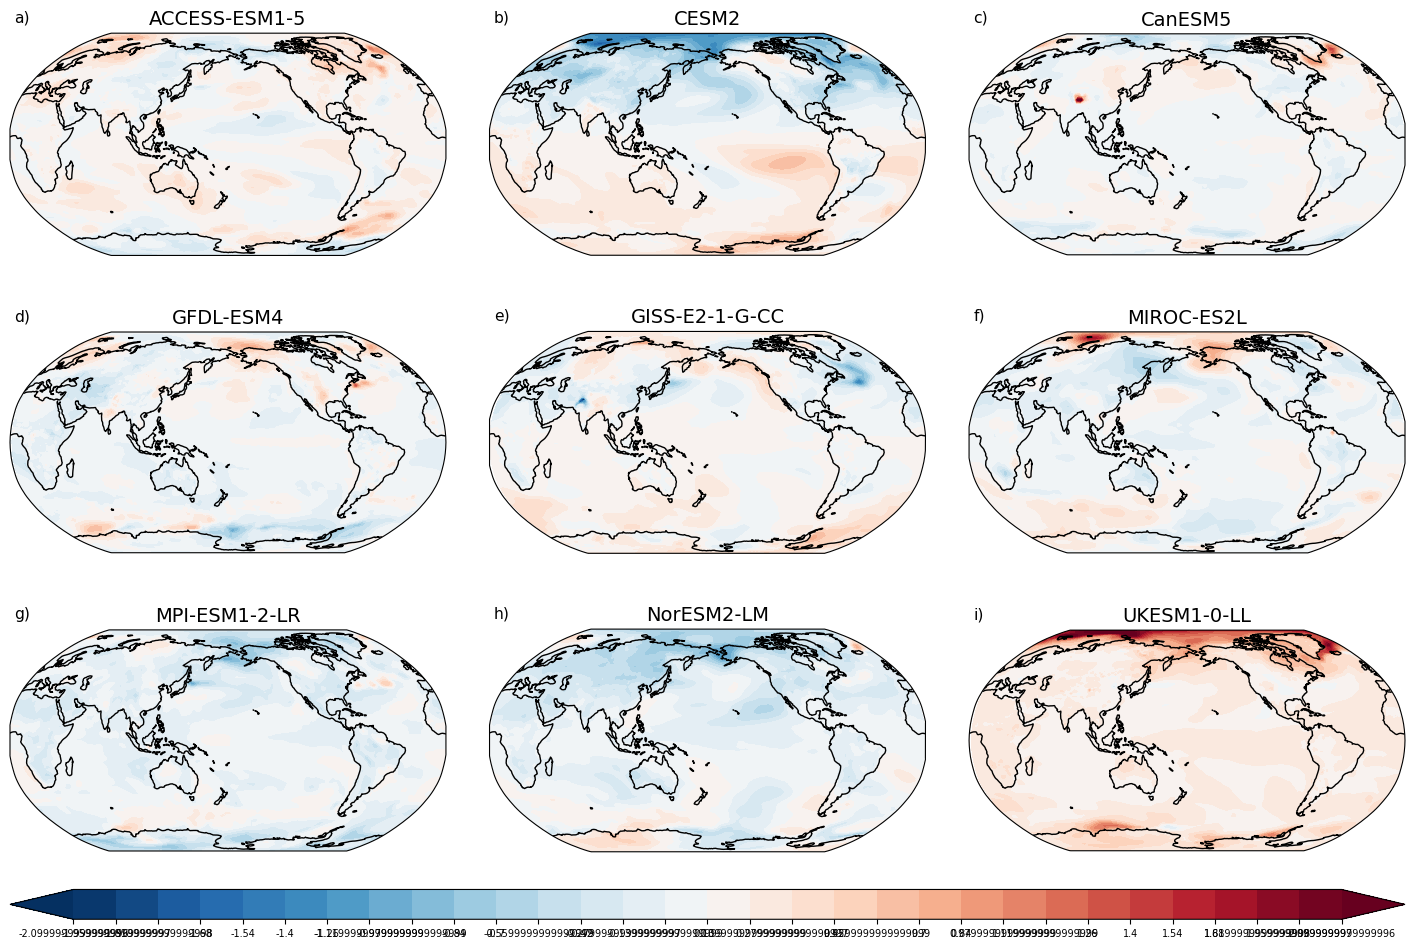

In [212]:
models = zec25_local_xrlist.refkeys
nrows = 4; ncols = 3
fig = plt.figure(figsize=(6*ncols, 4*ncols))
gs = gridspec.GridSpec(nrows, ncols, height_ratios = [1]*3 + [0.1], hspace=0, wspace=0.1)
cax = plt.subplot(gs[3, :])

zec_kwargs = dict(extend='both', cmap='RdBu_r', font_scale=0.7)

fig, gs, axes1, cbar = sn_plotting.map_plot_all_for_coords_3(
    zec25_local_xrlist.mean(dim='ensemble'),levels=np.arange(-3, 3.2, .2), fig=fig, gs=gs, cax=cax, add_colorbar=True,
    logginglevel='ERROR', **zec_kwargs)

In [213]:
# ZEC25 starts at year 15, base period finishes year 10 => 5 years
esmpi_zec25_local_xrlist = esmpi_xrlist.apply(calculate_rolling_period_diff, 5)

# ZEC50 starts at year 40, base period finishes year 10 => 30 years
esmpi_zec50_local_xrlist = esmpi_xrlist.apply(calculate_rolling_period_diff, 30)

In [214]:
# ZEC90 starts at year 80, base period finishes year 10 => 70 years
esmpi_zec90_local_xrlist = esmpi_xrlist.apply(calculate_rolling_period_diff, 70)

In [215]:
def create_range_analysis(esmpi_xrlist: xr.Dataset, zec_xrlist: xr.Dataset) -> xr.Dataset:
    """
    Create a range analysis of temperature anomalies compared to pre-industrial (PI) levels.

    Parameters:
        esmpi_xrlist (xr.Dataset): Dataset containing temperature anomalies for different models (ensemble members).
        zec_xrlist (xr.Dataset): Dataset containing ZEC50 values (previously calculated) for each model.

    Returns:
        xr.Dataset: Dataset containing information about whether the temperature anomalies are outside the 1st and 99th percentiles 
                    compared to pre-industrial levels for each model and time step.
    """
    # Calculate the upper and lower bounds for each model using the 1st and 99th percentiles
    upper_bound_xrlist = esmpi_xrlist.apply(xe.percentile, dim='time', q=90).set_refkeys('model')
    lower_bound_xrlist = esmpi_xrlist.apply(xe.percentile, dim='time', q=10).set_refkeys('model')
    
    # Find the time steps where temperature anomalies are warmer than the upper bound (99th percentile)
    warmer_than_pi_xrlist = zec_xrlist.greater_than(upper_bound_xrlist, 1, 0)
    
    # Find the time steps where temperature anomalies are cooler than the lower bound (1st percentile)
    cooler_than_pi_xrlist = zec_xrlist.less_than(lower_bound_xrlist, -1, 0) 
    
    # Combine the two results to get a final analysis of temperature anomalies compared to pre-industrial levels
    pi_comparison_xrlist = warmer_than_pi_xrlist + cooler_than_pi_xrlist
    
    # Compute the results to get a concrete Dataset
    pi_comparison_xrlist = pi_comparison_xrlist.compute()
    
    return pi_comparison_xrlist


In [216]:
pi_comparison_zec25_xrlist = create_range_analysis(esmpi_zec25_local_xrlist, zec25_local_xrlist)

In [217]:
pi_comparison_zec50_xrlist = create_range_analysis(esmpi_zec25_local_xrlist, zec50_local_xrlist)

In [218]:
pi_comparison_zec90_xrlist = create_range_analysis(esmpi_zec90_local_xrlist, zec90_local_xrlist)

### Testing Below => Cold / Above => Warm Hypothesis

In [219]:
# Testing that all the 1st percentile values are below 0. 
# This implies ZEC < 1st percenilte < 0 => ZEC < 0 
for model, ds in esmpi_zec25_local_xrlist.apply(xe.percentile, dim='time', q=1).set_refkeys('model'):
    all_below_0 = np.all(ds.values < 0)
    print(f'{model} - {all_below_0=}')

ACCESS-ESM1-5 - all_below_0=True
CESM2 - all_below_0=True
CanESM5 - all_below_0=True
GFDL-ESM4 - all_below_0=True
GISS-E2-1-G-CC - all_below_0=True
MIROC-ES2L - all_below_0=True
MPI-ESM1-2-LR - all_below_0=True
NorESM2-LM - all_below_0=True
UKESM1-0-LL - all_below_0=True


In [220]:
sm_test_99 = esmpi_zec50_local_xrlist.apply(xe.percentile, dim='time', q=99).set_refkeys('model')['GISS-E2-1-G-CC']
sm_test_01 = esmpi_zec50_local_xrlist.apply(xe.percentile, dim='time', q=1).set_refkeys('model')['GISS-E2-1-G-CC']

In [221]:
condition = sm_test_99 < 0

In [222]:
np.where(condition.squeeze())

(array([59, 59, 60, 60, 61, 61, 64, 65]),
 array([28, 29, 28, 30, 28, 29, 46, 27]))

In [223]:
lat_inds, lon_inds = np.where(condition.squeeze())

In [224]:
lat_lon_pairs = [(sm_test_99.lat.values[i], sm_test_99.lon.values[j]) for i, j in zip(lat_inds, lon_inds)]

In [225]:
lat_lon_pairs

[(29.0, 71.25),
 (29.0, 73.75),
 (31.0, 71.25),
 (31.0, 76.25),
 (33.0, 71.25),
 (33.0, 73.75),
 (39.0, 116.25),
 (41.0, 68.75)]

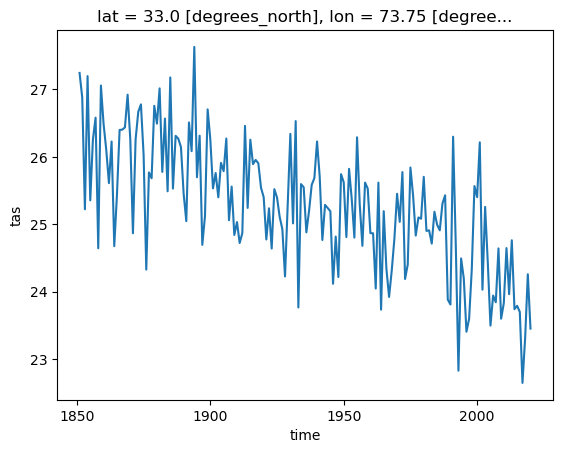

In [226]:
ilatlon = 5
esmpi_xrlist['GISS-E2-1-G-CC'].sel(lat=lat_lon_pairs[ilatlon][0], lon=lat_lon_pairs[ilatlon][1]).plot()

In [227]:
xr.where(sm_test_99<0, 1, 0).sum().values

array(8)

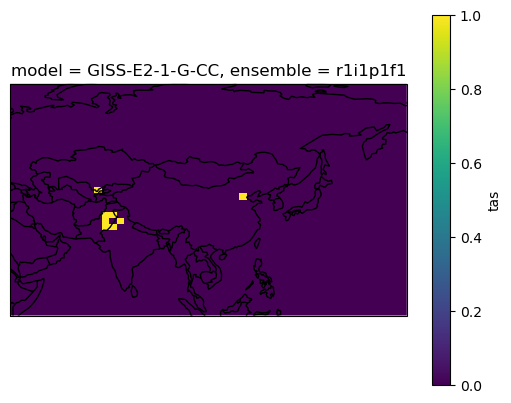

In [228]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
xr.where(sm_test_99<0, 1, 0).plot(ax=ax); ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_extent([40, 170, 0, 60])

In [229]:
# For the trends to be considered warming, they must be warmer than these values.
for latlon in lat_lon_pairs:
    value_99 = sm_test_99.sel(lat=latlon[0], lon=latlon[1]).values[0]
    value_01 = sm_test_01.sel(lat=latlon[0], lon=latlon[1]).values[0]
    val_zec50 = zec50_local_xrlist['GISS-E2-1-G-CC'].sel(lat=latlon[0], lon=latlon[1]).values[0][0]
    print(f'{val_zec50:.2f} ({value_01:.2f} to {value_99:.2f})')

-2.92 (-1.38 to -0.16)
-2.18 (-2.00 to -0.09)
-3.33 (-1.80 to -0.37)
-1.87 (-1.21 to -0.01)
-1.34 (-0.65 to -0.03)
-1.26 (-0.87 to -0.03)
-0.96 (-0.82 to -0.05)
-1.47 (-0.58 to -0.13)


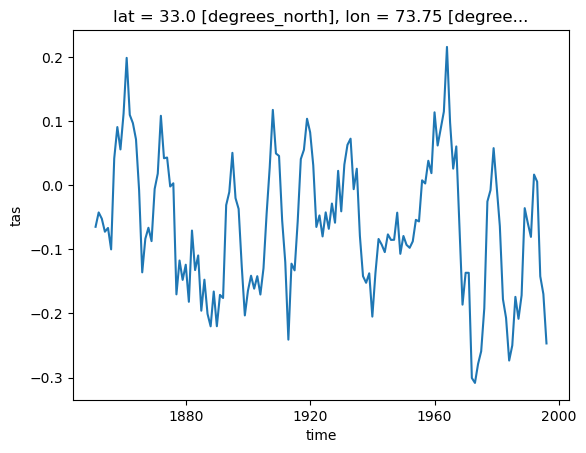

In [230]:
esmpi_zec25_local_xrlist['GISS-E2-1-G-CC'].sel(
    lat=lat_lon_pairs[ilatlon][0], lon=lat_lon_pairs[ilatlon][1]).plot()

In [231]:
ilatlon = 1
esmpi_zec25_local_xrlist.apply(xe.percentile, dim='time', q=99).set_refkeys('model')['GISS-E2-1-G-CC'].sel(
    lat=lat_lon_pairs[ilatlon][0], lon=lat_lon_pairs[ilatlon][1]).values

array([0.10081606])

In [232]:
for model, ds in esmpi_zec25_local_xrlist.apply(xe.percentile, dim='time', q=99).set_refkeys('model'):
    all_above_0 = np.all(ds.values > 0)
    print(f'{model} - {all_above_0=}')

ACCESS-ESM1-5 - all_above_0=True
CESM2 - all_above_0=True
CanESM5 - all_above_0=True
GFDL-ESM4 - all_above_0=True
GISS-E2-1-G-CC - all_above_0=True
MIROC-ES2L - all_above_0=True
MPI-ESM1-2-LR - all_above_0=True
NorESM2-LM - all_above_0=True
UKESM1-0-LL - all_above_0=True


## Plotting

In [233]:
models = pi_comparison_zec25_xrlist.refkeys
models

array(['ACCESS-ESM1-5', 'CESM2', 'CanESM5', 'GFDL-ESM4', 'GISS-E2-1-G-CC',
       'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL'],
      dtype='<U14')

In [234]:
zec50_local_regrid_xrlist = zec50_local_xrlist.mean(dim='ensemble').regrid('MPI-ESM1-2-LR', 'bilinear')
zec50_local_regrid_ds = xr.concat(zec50_local_regrid_xrlist.to_list(), dim='model')

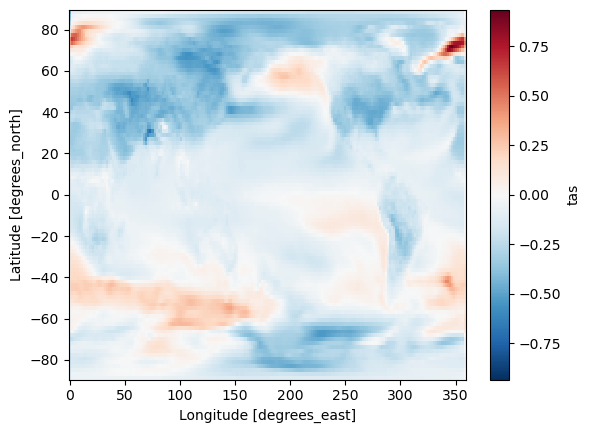

In [235]:
zec50_local_regrid_ds.mean(dim='model').plot()

In [236]:
# Regriddging
pi_comparison_regrid_zec25_xrlist = pi_comparison_zec25_xrlist.regrid('MPI-ESM1-2-LR', 'nearest_s2d')
pi_comparison_regrid_zec25_xrlist = pi_comparison_regrid_zec25_xrlist.isel(ensemble=0)
pi_comparison_regrid_zec25_ds = xr.concat(pi_comparison_regrid_zec25_xrlist.to_list(), dim='model')

pi_comparison_regrid_zec50_xrlist = pi_comparison_zec50_xrlist.regrid('MPI-ESM1-2-LR', 'nearest_s2d')
pi_comparison_regrid_zec50_xrlist = pi_comparison_regrid_zec50_xrlist.isel(ensemble=0)
pi_comparison_regrid_zec50_ds = xr.concat(pi_comparison_regrid_zec50_xrlist.to_list(), dim='model')

In [237]:
pi_comparison_regrid_zec90_xrlist = pi_comparison_zec90_xrlist.regrid('MPI-ESM1-2-LR', 'nearest_s2d')
pi_comparison_regrid_zec90_xrlist = pi_comparison_regrid_zec90_xrlist.isel(ensemble=0)
pi_comparison_regrid_zec90_ds = xr.concat(pi_comparison_regrid_zec90_xrlist.to_list(), dim='model')

In [238]:
levels = [-1, 0, 1]

In [239]:
number_models = len(models); number_models

9

In [240]:
discrete_cmap = pf.create_discrete_cmap('RdBu_r', levels=levels)

In [241]:
cmap_red = plt.cm.get_cmap('YlOrRd', 10)
cmap_blue = plt.cm.get_cmap('YlGnBu', 10)

In [242]:
reload(plotting_functions)

<module 'plotting_functions' from '/home/563/ab2313/Documents/PhD/modules/plotting_functions.py'>

In [243]:
num_plot_levels = np.arange(0,11)
num_plot_levels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

Text(-0.15, 0.5, 'ZEC90')

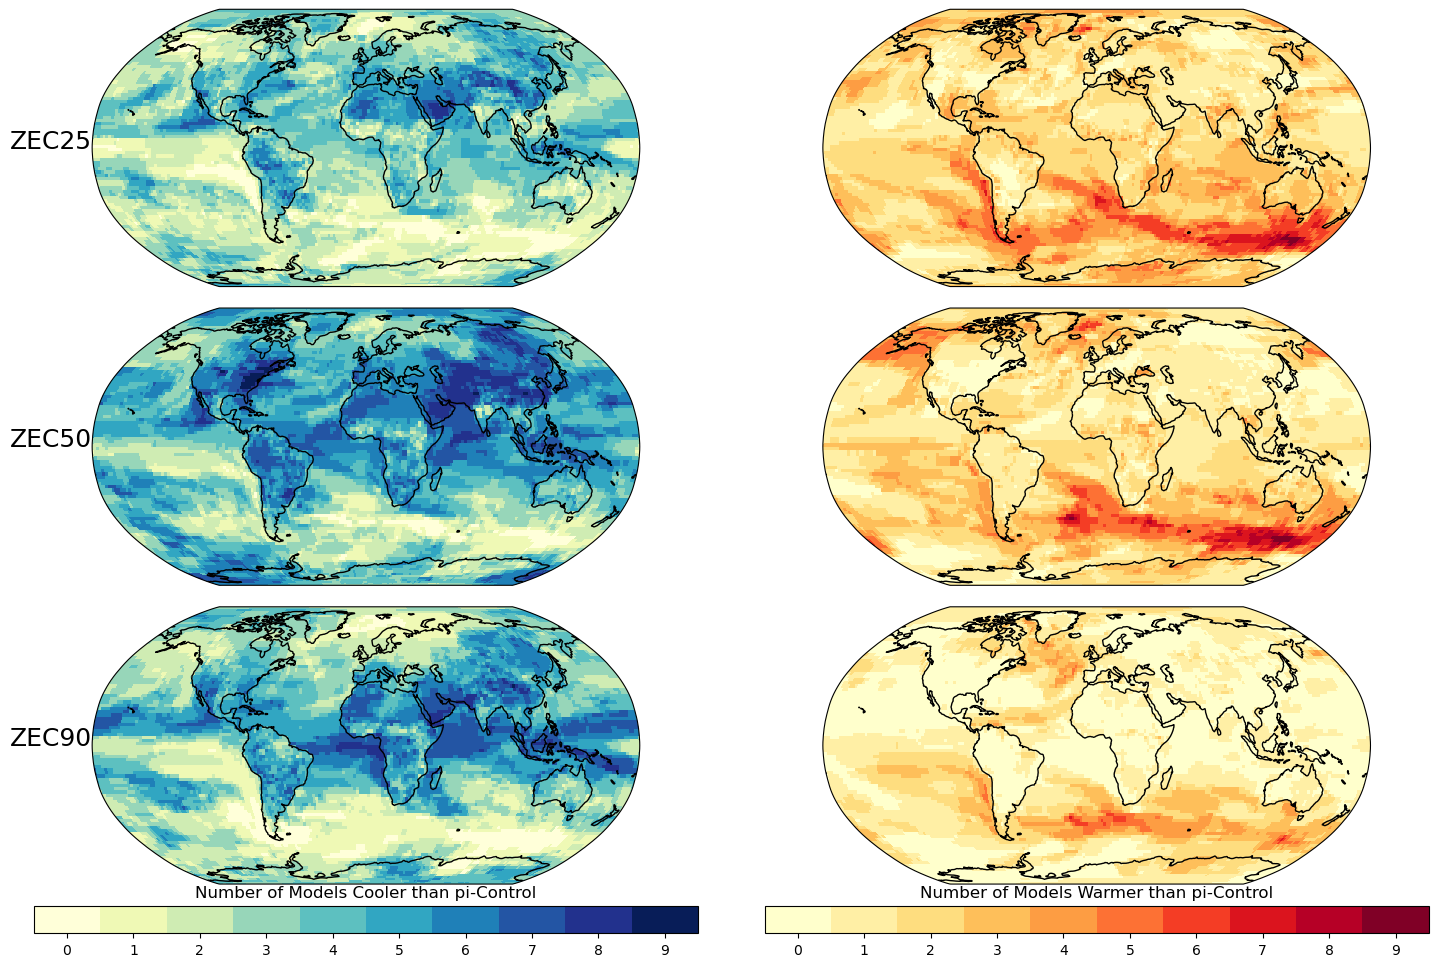

In [244]:
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(4, 2, wspace=.1, hspace=.1, height_ratios=[1, 1, 1, 0.1])

axes = [fig.add_subplot(gs[i], projection=ccrs.Robinson()) for i in range(0, 6)]
[ax.coastlines() for ax in axes]

total_number_kwargs = dict(levels=num_plot_levels, transform=ccrs.PlateCarree(), add_colorbar=False) #vmax=9, vmin=0

### Cool
# ZEC25
cool_plot = pi_comparison_regrid_zec50_ds.where(pi_comparison_regrid_zec25_ds < 0).sum(dim='model').pipe(np.abs).plot(ax=axes[0], cmap=cmap_blue,**total_number_kwargs)
# ZEC50
pi_comparison_regrid_zec50_ds.where(pi_comparison_regrid_zec50_ds < 0).sum(dim='model').pipe(np.abs).plot(ax=axes[2], cmap=cmap_blue,**total_number_kwargs)
# ZEC90
pi_comparison_regrid_zec90_ds.where(pi_comparison_regrid_zec90_ds < 0).sum(dim='model').pipe(np.abs).plot(ax=axes[4], cmap=cmap_blue,**total_number_kwargs)

plotting_functions.create_colorbar(cool_plot, cax=plt.subplot(gs[3, 0]), levels=num_plot_levels, cbar_title='Number of Models Cooler than pi-Control', 
                                  tick_offset='center')

### Warm
# ZEC25
warm_plot = pi_comparison_regrid_zec25_ds.where(pi_comparison_regrid_zec25_ds > 0).sum(dim='model').plot(ax=axes[1], cmap=cmap_red,**total_number_kwargs)
# ZEC50
pi_comparison_regrid_zec50_ds.where(pi_comparison_regrid_zec50_ds > 0).sum(dim='model').plot(ax=axes[3], cmap=cmap_red,**total_number_kwargs)
# ZEC90
pi_comparison_regrid_zec90_ds.where(pi_comparison_regrid_zec90_ds > 0).sum(dim='model').plot(ax=axes[5], cmap=cmap_red,**total_number_kwargs)


cbar = plotting_functions.create_colorbar(warm_plot, cax=plt.subplot(gs[3, 1]), levels=num_plot_levels, cbar_title='Number of Models Warmer than pi-Control', 
                                  tick_offset='center', logginglevel='ERROR')

axes[0].annotate('ZEC25', xy=(-0.15, 0.5), xycoords='axes fraction', fontsize=18)
axes[2].annotate('ZEC50', xy=(-0.15, 0.5), xycoords='axes fraction', fontsize=18)
axes[4].annotate('ZEC90', xy=(-0.15, 0.5), xycoords='axes fraction', fontsize=18)

Text(-0.15, 0.5, 'ZEC50')

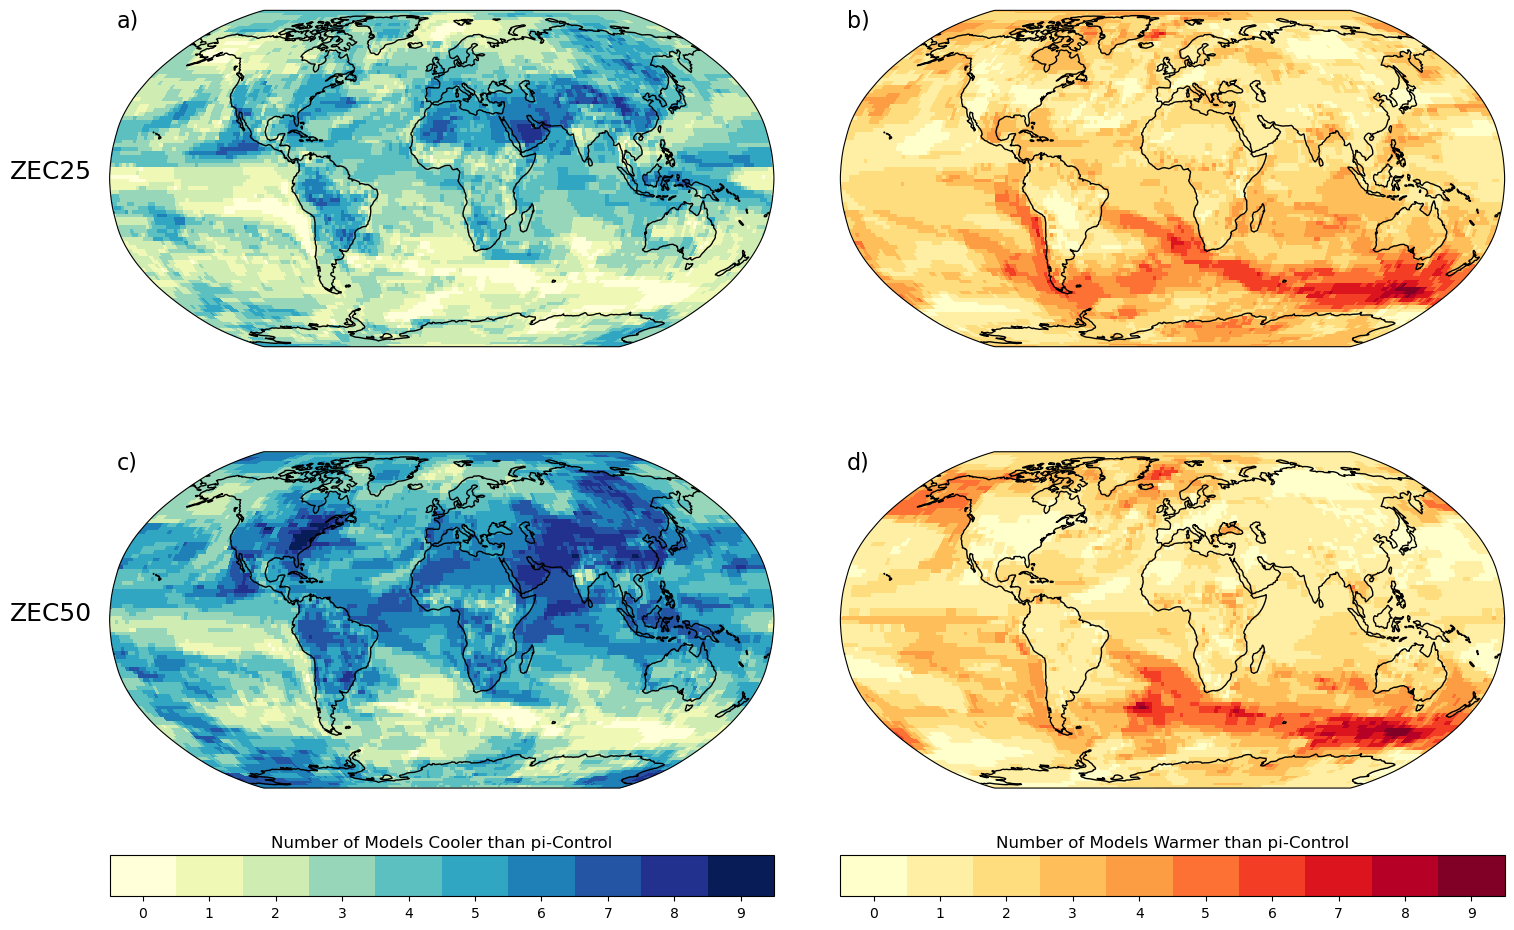

In [245]:
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(3, 2, wspace=.1, hspace=.1, height_ratios=[1, 1, 0.1])

axes = [fig.add_subplot(gs[i], projection=ccrs.Robinson()) for i in range(0, 4)]
[ax.coastlines() for ax in axes]

total_number_kwargs = dict(levels=num_plot_levels, transform=ccrs.PlateCarree(), add_colorbar=False) #vmax=9, vmin=0

### Cool
# ZEC25
cool_plot = pi_comparison_regrid_zec50_ds.where(pi_comparison_regrid_zec25_ds < 0).sum(dim='model').pipe(np.abs).plot(ax=axes[0], cmap=cmap_blue,**total_number_kwargs)
# ZEC50
pi_comparison_regrid_zec50_ds.where(pi_comparison_regrid_zec50_ds < 0).sum(dim='model').pipe(np.abs).plot(ax=axes[2], cmap=cmap_blue,**total_number_kwargs)
plotting_functions.create_colorbar(cool_plot, cax=plt.subplot(gs[2, 0]), levels=num_plot_levels, cbar_title='Number of Models Cooler than pi-Control', 
                                  tick_offset='center')

### Warm
# ZEC25
warm_plot = pi_comparison_regrid_zec25_ds.where(pi_comparison_regrid_zec25_ds > 0).sum(dim='model').plot(ax=axes[1], cmap=cmap_red,**total_number_kwargs)
# ZEC50
pi_comparison_regrid_zec50_ds.where(pi_comparison_regrid_zec50_ds > 0).sum(dim='model').plot(ax=axes[3], cmap=cmap_red,**total_number_kwargs)

cbar = plotting_functions.create_colorbar(warm_plot, cax=plt.subplot(gs[2, 1]), levels=num_plot_levels, cbar_title='Number of Models Warmer than pi-Control', 
                                  tick_offset='center', logginglevel='ERROR')


# Adding in the figures labels
for num, ax in enumerate(axes): plotting_functions.add_figure_label(ax, f'{chr(97+num)})', y=0.95)

axes[0].annotate('ZEC25', xy=(-0.15, 0.5), xycoords='axes fraction', fontsize=18)
axes[2].annotate('ZEC50', xy=(-0.15, 0.5), xycoords='axes fraction', fontsize=18)

In [246]:
pi_comparison_zec25_xrlist = pi_comparison_zec25_xrlist.sort_by_refkey()

In [247]:
models = pi_comparison_zec25_xrlist.refkeys
models

array(['ACCESS-ESM1-5', 'CESM2', 'CanESM5', 'GFDL-ESM4', 'GISS-E2-1-G-CC',
       'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL'],
      dtype='<U14')

In [248]:
levels = [-1, 0, 1]
discrete_cmap = pf.create_discrete_cmap('PuOr', levels=levels)

In [249]:
from matplotlib.colors import ListedColormap

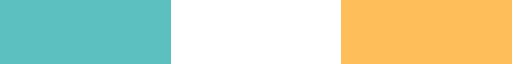

In [250]:
above_below_cmap = ListedColormap( [cmap_blue(np.arange(10))[4], 'white', cmap_red(np.arange(10))[3]])
above_below_cmap

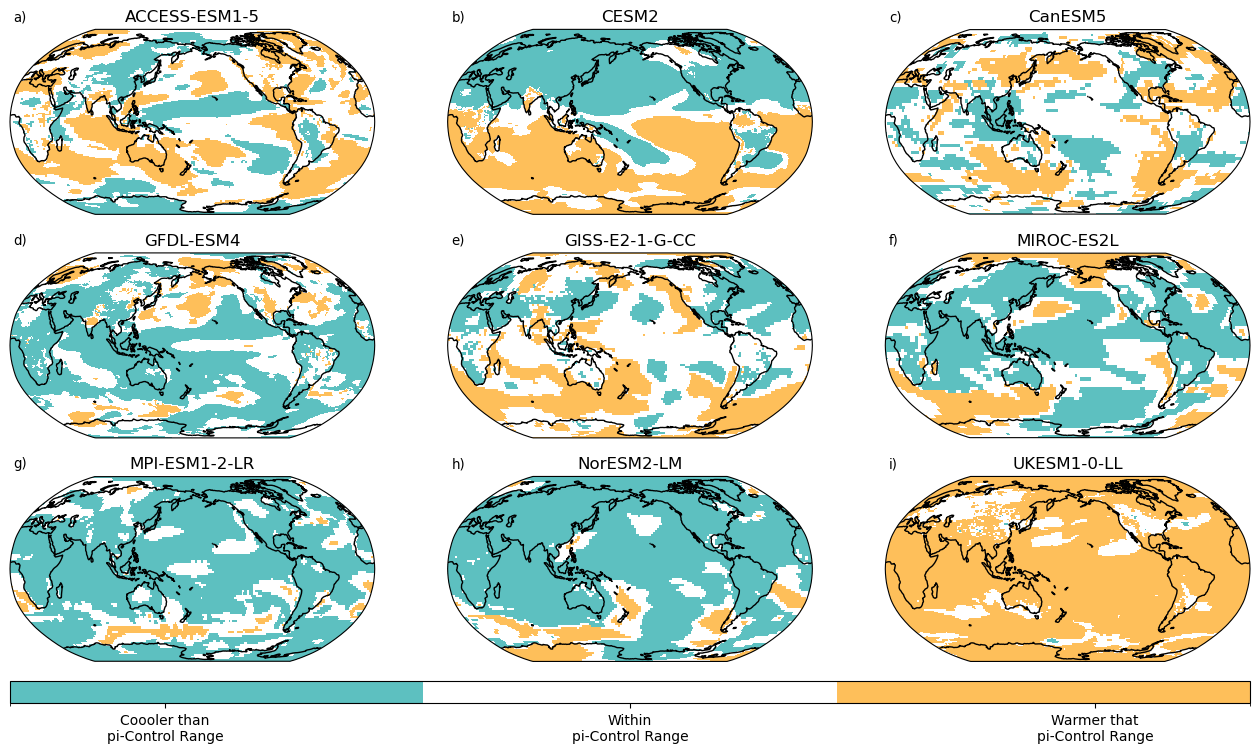

In [251]:
fig = plt.figure(figsize=(16, 9))
gs = gridspec.GridSpec(4, 3, height_ratios=[1] * 3 + [0.1], hspace=0)
cax = plt.subplot(gs[3, :])
axes = [fig.add_subplot(gs[i], projection=ccrs.Robinson(central_longitude=180)) for i in range(9)]

for num, (ax, model) in enumerate(zip(axes, models)):
    c = pi_comparison_zec25_xrlist[model].mean(dim='ensemble').plot(
        ax=ax, vmin=-1, vmax=1, transform=ccrs.PlateCarree(), cmap=above_below_cmap, add_colorbar=False, 
        rasterized=True)
    ax.set_title(f'{model}')
    ax.coastlines()
    plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.6)
    
cbar = plotting_functions.create_colorbar(c, cax, levels=levels)
cbar.set_ticks([-0.75, 0, 0.75])
cbar.ax.set_xticklabels(['Coooler than\npi-Control Range', 'Within\npi-Control Range', 'Warmer that\npi-Control Range']);

# Global Average Time Series

In [252]:
def convert_to_0_start_cdftime(time, freq='Y'):
    t0, tf = np.take(time, [0,-1])

    t0_new = cftime.datetime(1, 1, 1, 0, 0, 0, 0, calendar='gregorian')
    # New end time is the total length of the old dataset added to t0


    tf_new = t0_new + (tf - t0) if freq is None else None


    new_time = xr.cftime_range(start = t0_new, end = tf_new, periods = len(ds['time'].values), 
                           freq=freq)
    
    return new_time

In [253]:
a1_smean_anom_xrlist

key_dim = model


Number of da/ds: 9
---------------
['ACCESS-ESM1-5']({'ensemble': 1, 'model': 1, 'time': 101})
['CESM2']       ({'ensemble': 1, 'model': 1, 'time': 150})
['CanESM5']     ({'ensemble': 3, 'model': 1, 'time': 100})
['GFDL-ESM4']   ({'ensemble': 1, 'model': 1, 'time': 200})
['GISS-E2-1-G-CC']({'ensemble': 1, 'model': 1, 'time': 180})
['MIROC-ES2L']  ({'ensemble': 1, 'model': 1, 'time': 248})
['MPI-ESM1-2-LR']({'ensemble': 1, 'model': 1, 'time': 185})
['NorESM2-LM']  ({'ensemble': 1, 'model': 1, 'time': 100})
['UKESM1-0-LL'] ({'ensemble': 4, 'model': 1, 'time': 330})

In [254]:
time = a1_smean_anom_xrlist['UKESM1-0-LL'].time.values
time_0_start = convert_to_0_start_cdftime(ds.time.values)

AttributeError: 'DataArray' object has no attribute 'time'

In [ ]:
# Assuming your time_0_start is a list or array of cftime objects
min_year = min([date.year for date in time_0_start])
max_year = max([date.year for date in time_0_start[:101]])


# Create a list of years from min_year to max_year at 25-year intervals
years_25 = list(range(min_year, max_year+25, 25))
years_25 = np.array(years_25)-1
years_25

In [ ]:

# Convert the years to cftime objects (you might need to adjust the cftime object type based on your data)
ticks = [cftime.DatetimeNoLeap(year, 1, 1) for year in years_25]

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(9, 1, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds_multi_ens) in enumerate(a1_smean_anom_xrlist):
    ensembles = ds_multi_ens.ensemble.values
    for ensemble in ensembles:
        ds_vals = ds_multi_ens.sel(ensemble=ensemble).isel(time=slice(None, 101)).squeeze().values
        ax = axes[num]
        ax.plot(time_0_start[:len(ds_vals)], ds_vals, label=ensemble)
        ax.annotate(model, xy=(0.02, 0.75), fontsize=14, xycoords='axes fraction')
        
        # Manually set x-axis ticks and labels
        ax.set_xticks(ticks)
        ax.set_xticklabels(years_25)        
    if len(ensembles) > 1: ax.legend(ncol=len(ensembles), loc='best')
    ax.set_ylabel('GMST\nAnomaly\n'+r'($^\circ C$)', rotation=0, labelpad=20)

ax.set_xlabel('Time After Cessation of Emissions (years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(9, 1, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds) in enumerate(esmpi_smean_xrlist):
    ax = axes[num]
    time = convert_to_0_start_cdftime(ds.time.values)
    ax.plot(time,ds.squeeze())
    ax.annotate(model, xy=(0.02, 0.75), fontsize=14, xycoords='axes fraction')

In [ ]:
models = esmpi_smean_xrlist.refkeys
ncols = 3; nrows = int(np.ceil(len(models)/2))

fig = plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, hspace=0.6)

for num, (model, ds) in enumerate(esmpi_smean_xrlist):
    ax = fig.add_subplot(gs[num])
    time = convert_to_0_start_cdftime(ds.time.values)
    ax.plot(time,ds.squeeze())
    
    plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.8)
    ax.set_title(model); ax.set_ylabel(r'GMST $(^\circ C)$'); ax.set_xlabel('Time after net zero emissions (years)')
    # ax.set_xlim([time[0], time[-1]])
    
    init_y = ds.squeeze().values
    x = np.arange(len(init_y))
    grad_yint = np.polyfit(x, init_y, deg=1)

    fitted_line = np.polyval(grad_yint, x)
    mk_val = pymannkendall.original_test(init_y)
    mk_pval = mk_val.p
    if mk_pval < 0.05:
        color = 'red'
        label = f'Gradient = {grad_yint[0]*50:.2f}' + r'$^\circ$C (50yr)$^{-1}$' + f'\np-value = {mk_pval:.3f}'
    else:
        color='grey'
        label=None
    
    ax.plot(time, fitted_line, linestyle='--', alpha=0.6, color=color, label=label)
    if mk_pval < 0.05: ax.legend(ncol=1, loc='best')#bbox_to_anchor=(0.6, 1.06))